In [3]:
try:
  from torchcontrib.optim import SWA
  import pytorch_lightning as pl
  import comet_ml

  #!wandb login
except:
  %pip install torchcontrib
  %pip install pytorch_lightning
  %pip install comet_ml
finally:
  from torchcontrib.optim import SWA
  import pytorch_lightning as pl
  import comet_ml

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence

from torch.optim import Adam, Adamax
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
  #!wandb login

In [4]:
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CometLogger
#from pytorch_lightning.callbacks.StochasticWeightAveraging import StochasticWeightAveraging

In [5]:
import pandas as pd
import numpy as np

from copy import deepcopy

import os
from google.colab import drive

from itertools import compress, chain

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

from typing import Dict, Tuple, Optional, List

from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
if not os.path.exists("/content/drive"):
  drive.mount("/content/drive")

In [7]:
split_ratio = .8 
torch.set_default_dtype(torch.double)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#transformations =  transforms.Compose(
#    [transforms.Normalize()]
#)

hparams = {
    "dataset":
    {
        "train":
        {
            "transforms": None,
            "batch_size": 128, #4048,
            "root_dir": "/content/drive/MyDrive/genomics",
            "max_length": 142,
            "filename": "train_sequences.txt",
        },
        "test":
        {
            "transforms": None,
            "batch_size": 128, #4048,
            "root_dir": "/content/drive/MyDrive/genomics",
            "max_length": 142,
            "filename": "test_sequences.txt"
        }
    },
    "model":
    {
        "training": {
            "init_lr": 1e-3,
            "min_lr": 1e-6,
            "reduce_on_plateau_patience": 50,
            "factor": 0.5,
            "weight_decay": 0,
        },
        "backbone":{
            "channels": [1, 2048],
            "depths": [1],
            "p": [None],
            "use_pooling": [False],
            "kernel_sizes": [(141, 4)],
            "strides": [(1, 1)],
        },
        "head":{
            "residualize": [False],
            "dims": [256 * 16, 1],
        }
    }
}

In [8]:
#Deeper model
hparams["model"]["backbone"]["kernel_sizes"] = [(72, 4), (70, 1)]
hparams["model"]["backbone"]["strides"] = [(1, 1), (1, 1)]
hparams["model"]["backbone"]["use_pooling"] = [False, False]
hparams["model"]["backbone"]["p"] = [None, None]
hparams["model"]["backbone"]["channels"] = [1, 256, 256]
hparams["model"]["backbone"]["depths"] = [1, 1, 1]

hparams["model"]["head"]["dims"] = [512, 1]

In [9]:
class SeqDataset(Dataset):

  def __init__(self, **hparams):

    super().__init__()

    self.root_dir = hparams.get("root_dir")
    self.filename = hparams.get("filename")
    self.maximal_length = hparams.get("max_length")
    self.transforms = hparams.get("transforms")

    self.encoder = LabelEncoder()
    self.data_buffer = pd.read_csv(os.path.join(self.root_dir, self.filename), 
                          delimiter='\t', names=("seq", "value"))
    
    self.data_buffer = self.data_buffer #testing purposes
    

    lengths = self.data_buffer["seq"].apply(len).values
    max_length = lengths.max()

    if self.maximal_length < max_length:

      self.data_buffer = self.data_buffer.drop(
          index=(self.data_buffer["seq"][self.data_buffer["seq"].apply(len) > self.maximal_length]).loc
      )
      
    
    self.encoder.fit(['A', 'T', 'G', 'C', 'N'])

  def __len__(self) -> int:

    return len(self.data_buffer)

  def __getitem__(self, ix: int) -> Dict[torch.Tensor, torch.Tensor]:

    seq, y = self.data_buffer.iloc[ix]
    seq_label_encoded = self.encoder.transform(list(seq))
    seq_tensor = torch.from_numpy(seq_label_encoded)

    #carefull with positioning, we shall align the sequence to the start
    if len(seq_label_encoded) < self.maximal_length:
      seq_tensor = torch.cat((seq_tensor, 3 * torch.ones(self.maximal_length - len(seq_label_encoded)))).long()

    y = torch.from_numpy(np.asarray(y))
    X = F.one_hot(seq_tensor, num_classes=5)
    X = torch.cat((X[:,:-2], X[:,[-1]]), dim=1)

    #X = torch.tensor([[ix, ix, ix, ix]])
    #X = X[:10,:]
    #y = torch.argmax(X, 1)[[0]]
    #X[1:,:] = 0

    if self.transforms:
      X = self.transforms(X)

    X = X.unsqueeze(0)

    return {"X": X, "y": y}

In [10]:
dataset_train, dataset_test = SeqDataset(**hparams["dataset"]["train"]), SeqDataset(**hparams["dataset"]["test"])
n = len(dataset_train)
dataset_train, dataset_val = random_split(dataset_train, [int(split_ratio * n), n - int(split_ratio * n)])

dataloader_train = DataLoader(dataset_train, batch_size=hparams["dataset"]["train"]["batch_size"])
dataloader_val = DataLoader(dataset_val, batch_size=hparams["dataset"]["train"]["batch_size"])
dataloader_test = DataLoader(dataset_test, batch_size=hparams["dataset"]["test"]["batch_size"])

dataloaders = {

    "train": dataloader_train,
    "val": dataloader_val,
    "test": dataloader_test,
    
}

ParserError: ignored

In [11]:
class SimpleConvBlock(nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: Tuple[int], 
               strides: List[Tuple], depth: int, use_pooling=False, p: Optional[float]=None) -> None:

    super().__init__()

    if use_pooling:

      padding = (kernel_size[0] // 2)

      self.layers = [
                [
                  nn.Conv2d(in_channels if d == 0 else out_channels, out_channels, kernel_size, strides[d], 0, bias=True), 
                  nn.BatchNorm2d(out_channels),
                  nn.PReLU(1), #out_channels),
                  nn.Dropout2d(p) if p else nn.Identity()
                  ]   
                for d in range(depth)
      ] + [[nn.AdaptiveMaxPool2d(1)]]

    else:
      self.layers = [
                [
                  nn.Conv2d(in_channels if d == 0 else out_channels, out_channels, kernel_size, strides[d], 0, bias=True), 
                  nn.BatchNorm2d(out_channels),
                  nn.PReLU(1), #out_channels),
                  nn.Dropout2d(p) if p else nn.Identity()
                  ]
                for d in range(depth)
      ]

    self.layers = list(chain.from_iterable(self.layers))

    self.block = nn.Sequential(
        *self.layers
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    x = self.block(x)

    return x

class Residualize(nn.Module):

  def __init__(self, module: nn.Module, type_:str="fc") -> None:

    super().__init__()

    self.module = module
    self.type = type_

  def forward(self, X: torch.Tensor) -> torch.Tensor:

    if self.type == "fc":
      X = X + self.module(X)
    else:
      pass

    return X
    


In [12]:
class SimpleConvNet(pl.LightningModule):

  def __init__(self, **hparams) -> None:

    super().__init__()

    self.save_hyperparameters()
    self.automatic_optimization = True #False
    self.learning_rate = self.hparams["model"]["training"]["init_lr"]

    self.layers = [
                   
          SimpleConvBlock(
              self.hparams["model"]["backbone"]["channels"][i], 
              self.hparams["model"]["backbone"]["channels"][i + 1],
              self.hparams["model"]["backbone"]["kernel_sizes"][i],
              self.hparams["model"]["backbone"]["strides"][i],
              self.hparams["model"]["backbone"]["depths"][i],
              self.hparams["model"]["backbone"]["use_pooling"][i],
              self.hparams["model"]["backbone"]["p"][i] if self.hparams["model"]["backbone"]["p"] else None
          )
          for i in range(len(self.hparams["model"]["backbone"]["channels"]) - 1)

    ]

    self.backbone = nn.Sequential(*self.layers)
    self.head = nn.Sequential(
        *list(chain.from_iterable(
            [[nn.Flatten()]] + 
            [
             [
              Residualize(nn.Linear(self.hparams["model"]["head"]["dims"][d], self.hparams["model"]["head"]["dims"][d + 1])) if self.hparams["model"]["head"]["residualize"][d] \
              else nn.Linear(self.hparams["model"]["head"]["dims"][d], self.hparams["model"]["head"]["dims"][d + 1]),
              nn.BatchNorm1d(self.hparams["model"]["head"]["dims"][d + 1]) if d < len(self.hparams["model"]["head"]["dims"]) - 2 else nn.Identity(),
              nn.PReLU(num_parameters=1) if d < len(self.hparams["model"]["head"]["dims"]) - 2 else nn.Identity() #self.hparams["head"]["dims"][d + 1]),
              ]
             for d in range(len(self.hparams["model"]["head"]["dims"]) - 1)]
        ))
    )

    self.model = nn.Sequential(
        self.backbone,
        self.head,
    )

    self.loss = nn.MSELoss()

  def log_dist(self, y: torch.Tensor, y_hat: torch.Tensor) -> None:
    
    y = y.squeeze()

    sns.kdeplot(y)
    sns.kdeplot(y_hat)

    self.logger.log_figure(figure=sns.get_figure())

  @torch.no_grad()
  def metric(self, y: torch.Tensor, y_hat: torch.Tensor) -> float:

    metric = r2_score(y, y_hat)

    return metric

  def loss_func(self, y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:

    return self.loss(y_hat, y)

  def configure_optimizers(self):

    optimizer = Adam([{"params": self.model.parameters(), "lr": self.hparams["model"]["training"]["init_lr"]}],
                     lr=self.learning_rate,#self.hparams["training"]["init_lr"],
                     weight_decay=self.hparams["model"]["training"]["weight_decay"])
    lr_scheduler_1 = ReduceLROnPlateau(optimizer, 
                                     mode="min", 
                                     min_lr=self.learning_rate,#self.hparams["model"]["training"]["min_lr"],
                                     factor=self.hparams["model"]["training"]["factor"],
                                     patience=self.hparams["model"]["training"]["reduce_on_plateau_patience"],
                                     threshold=1e-3,
                                     )
    #lr_scheduler_2 = CosineAnnealingLR(optimizer,
    #                                   T_max=5,
    #                                   eta_min=1e-5)
    
    #return [optimizer], [lr_scheduler_1, lr_scheduler_2]
    return {
        "optimizer": optimizer,
        "scheduler": lr_scheduler_1,
        "monitor": "loss_train",
    }


  def forward(self, X: torch.Tensor) -> torch.Tensor:

    y_hat = self.model(X)
    
    return y_hat

  def _general_step(self, batch: Dict[str, torch.Tensor]) -> torch.Tensor:

    X, y = batch["X"], batch["y"]
    X, y = X.double(), y.double()

    #X = (X - X.mean()) / X.var()

    y_hat = self.forward(X)
    loss = self.loss_func(y, y_hat.squeeze(1))
    metric = self.metric(y, y_hat.squeeze(1))

    return loss, metric

  def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor: #Dict[str, torch.Tensor]:

    optimizer, lr_schedulers = self.optimizers(), self.lr_schedulers()

    #optimizer.zero_grad()

    loss, metric = self._general_step(batch)
    #self.manual_backward(loss)

    #optimizer.step()

    #if (batch_idx + 1) % self.hparams["training"]"] == 0:
    #lr_schedulers[1].step(loss)

    #grad_norm = self.trainer.callback_metrics
    self.log("loss", loss.detach().cpu().item(), prog_bar=True)
    self.log("r2", metric, prog_bar=True)


    #return {
    #    "loss-train": loss
    #}

    log = {
        "training_loss": loss.detach().cpu().item(),
        "training_r2": metric,
    }

    return {"loss": loss, "metric": metric, "log": log}


  def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor: #Dict[str, torch.Tensor]:

    loss, metric = self._general_step(batch)

    self.log("loss", loss.detach().cpu().item(), prog_bar=True)
    self.log("metric", metric, prog_bar=True)

    return {"loss": loss, "metric": metric, "log": log}

  def training_epoch_end(self, training_step_outputs) -> torch.Tensor:

    optimizer = self.optimizers()

    loss_epoch = torch.tensor([output["loss"] for output in training_step_outputs])
    loss_mean = loss_epoch.mean()

  def train_dataloader(self):

    dataset_train = SeqDataset(**self.hparams["dataset"]["train"])
    dataloader_train = DataLoader(dataset_train, batch_size=self.hparams["dataset"]["train"]["batch_size"])

    return dataloader_train
    #print(self.trainer.train_dataloaders)
    #idx = np.random.randint(len(self.trainer.train_dataloaders))
    #training_sample = self.trainer.train_dataloaders[idx]

    #print(optimizer.param_groups[0]['lr'])


  #  return loss_mean

  #def validation_epoch_end(self, validation_step_outputs) -> torch.Tensor:

  #  loss_epoch = torch.cat(validation_step_outputs)
  #  loss_mean = loss_epoch.mean()

  #  return loss_mean


In [13]:
model = SimpleConvNet(**hparams)

In [14]:
experiment = comet_ml.Experiment(
    api_key="ilhZ5PMVM28bCHxtbwUQOU2r0",
    project_name="general",
)

comet_logger = CometLogger(
    api_key="ilhZ5PMVM28bCHxtbwUQOU2r0",
    rest_api_key=comet_ml.get_config("comet.api_key"),
    project_name="dream",
    workspace="vamdemon",
    #optimizer_data=comet_ml.parameters,
)

trainer = Trainer(
    max_epochs=500,
    deterministic=True,
    track_grad_norm="inf",
    logger=comet_logger,
    gradient_clip_val=0.5,
    auto_lr_find=True,
    log_every_n_steps=1,
    #callbacks=EarlyStopping(monitor="loss_val", patience=5, mode="min"),
)

#trainer.tune(model)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: tensorboard, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/vamdemon/general/7c9ff4935fb44a8dab70689b20e79d87

CometLogger will be initialized in online mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

In [14]:
model.learning_rate = 1e-2 #1e-3 best

In [299]:
model.learning_rate

0.01

In [15]:
trainer.fit(
    model=model,
    #train_dataloaders=dataloaders["train"],
    #val_dataloaders=dataloaders["val"],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/optimizer.py:381: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  f"Found unsupported keys in the optimizer configuration: {set(extra_keys)}", category=RuntimeWarning

  | Name     | Type       | Params
----------------------------------------
0 | backbone | Sequential | 4.7 M 
1 | head     | Sequential | 513   
2 | model    | Sequential | 4.7 M 
3 | loss     | MSELoss    | 0     
----------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.653    Total estimated model params size (MB)
COMET WARNING: Comet has disabled auto-logging funct

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric wit

In [313]:
next(iter(model.backbone.parameters()))

Parameter containing:
tensor([[[[ 0.0416,  0.0016, -0.0319, -0.0101],
          [-0.0005, -0.0036,  0.0022, -0.0226],
          [ 0.0071, -0.0124, -0.0138,  0.0407],
          ...,
          [ 0.0384, -0.0218, -0.0015,  0.0231],
          [ 0.0285,  0.0058, -0.0143,  0.0121],
          [-0.0258, -0.0327, -0.0278,  0.0112]]],


        [[[-0.0252, -0.0144, -0.0291,  0.0149],
          [-0.0028, -0.0050,  0.0188,  0.0017],
          [-0.0227, -0.0386,  0.0334,  0.0005],
          ...,
          [ 0.0399,  0.0114,  0.0418, -0.0382],
          [-0.0006,  0.0290,  0.0279, -0.0397],
          [ 0.0173, -0.0340, -0.0391,  0.0189]]],


        [[[ 0.0421,  0.0157,  0.0162, -0.0046],
          [ 0.0375, -0.0099,  0.0333, -0.0169],
          [ 0.0219, -0.0197, -0.0177, -0.0139],
          ...,
          [-0.0254, -0.0208, -0.0389,  0.0282],
          [ 0.0214,  0.0365,  0.0090,  0.0173],
          [-0.0373,  0.0285,  0.0130, -0.0371]]],


        ...,


        [[[ 0.0191,  0.0335, -0.0130,  0.0

In [145]:
pwm_weights = next(iter(model.backbone.parameters()))

In [186]:
X.shape

torch.Size([8000, 1, 142, 4])

In [181]:
samples = list(dataloader_val)
X, y = [batch['X'] for batch in samples], [batch['y'] for batch in samples]
X, y = torch.cat(X), torch.cat(y)

KeyboardInterrupt: ignored

In [314]:
it = iter(dataloader_val)
next(it)
next(it)
next(it)
batch = next(it)
X, y = batch['X'], batch['y']

torch.Size([256, 1, 142, 4])
tensor([[ 7.7322, 11.0824],
        [12.9547, 12.5888],
        [11.0000, 11.9053],
        [ 9.6728, 10.5822],
        [ 9.7588,  8.6401],
        [15.2675, 11.9594],
        [ 9.0000, 10.6129],
        [ 9.7660,  9.9880],
        [ 9.0000,  9.8145],
        [ 8.6777, 10.1413],
        [ 2.1429, 11.2568],
        [10.1660, 11.4797],
        [ 8.2652, 11.3533],
        [11.0000, 10.6387],
        [11.0000, 10.2949],
        [11.5240,  9.8827],
        [13.0000, 11.5059],
        [ 9.2648, 10.6534],
        [12.2618, 11.5687],
        [15.0000, 11.4665],
        [10.0000,  9.5269],
        [13.0000, 10.3206],
        [ 3.2607,  9.5057],
        [14.4785,  9.3451],
        [16.0000, 11.0696],
        [15.0000, 12.8263],
        [ 8.0736,  9.2823],
        [ 9.6756, 10.5800],
        [14.2160, 10.4335],
        [ 5.2406, 10.6355],
        [11.1553, 10.0387],
        [12.0000, 12.0827],
        [10.4583, 10.3632],
        [11.0188, 10.2266],
        [ 9.5643,  

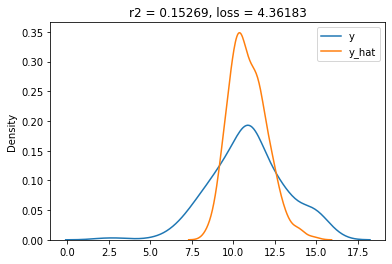

In [315]:
with torch.no_grad():

  #sample = samples[1]

  #X, y = sample['X'], sample['y']
  print(X.shape)
  y_hat = model(X.to(device, dtype=torch.double)).cpu().squeeze()
  y = y.squeeze()

  sns.kdeplot(y)
  sns.kdeplot(y_hat)

  e = y_hat - y
  metric = r2_score(y, y_hat)
  loss = F.mse_loss(y_hat, y)

  print(torch.stack((y, y_hat)).T)

  plt.legend(['y', "y_hat"])
  plt.title(f"r2 = {round(metric.item(), 5)}, loss = {round(loss.item(), 5)}")

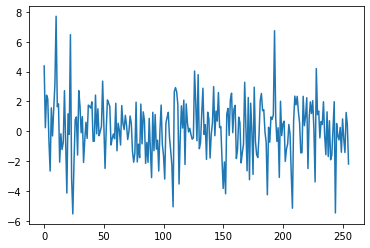

In [236]:
plt.plot(e)

In [237]:
e.mean(), e.var()

(tensor(0.1445), tensor(3.8374))

In [238]:
model_checkpoint = deepcopy(model)

In [239]:
torch.save(model.state_dict, "best_0501r2_full_train.chpt")

In [ ]:
from itertools import cycle

encoded = torch.from_numpy(encoder.fit_transform(list(seq.iloc[0,0])))

torch.zeros((len(encoded), 4), dtype=encoded.dtype).scatter_(
    dim=1,
    index=encoded.unsqueeze(1),
    src=torch.ones_like(encoded).unsqueeze(1),
    )

tensor([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0

In [ ]:
from itertools import cycle

In [ ]:
len(encoded)

110